# Experiment: Community Analysis - Graph Tast

**Author:** Felipe Cortes Jaramillo

**Description:** In this experiment we want to compute the communities within the block-chain data using three different algorithms: Louvain, Greedy Modulariy and Label Propagation. We then are going to plot different information regarding this communities and compare them with the increase of the bitcoin price.

**References:** We took inspiration on the following references when building the code:

- https://github.com/riki95/Bitcoin-Graph-study-with-NetworkX
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.label_propagation.label_propagation_communities.html

In [2]:
# Un-comment the following line to install the required packages

# !pip install networkx python-louvain plotly pyspark

In [3]:
# Import needed libraries

from pyspark.sql.functions import input_file_name, regexp_extract, col
from pyspark.sql import SparkSession
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import collections
from community import community_louvain

In [3]:
# First, we start uploading the Google Drive (If using the Cloud)

#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
spark = SparkSession.builder \
    .appName("Combine CSVs") \
    .getOrCreate()

In [5]:
# List of different Q's across years

file_pattern_15_Q1 = "./../data/data_no_tokenized/2015-Q1/*-*-*.csv"
file_pattern_15_Q2 = "./../data/data_no_tokenized/2015-Q2/*-*-*.csv"
file_pattern_15_Q3 = "./../data/data_no_tokenized/2015-Q3/*-*-*.csv"
file_pattern_15_Q4 = "./../data/data_no_tokenized/2015-Q4/*-*-*.csv"
file_pattern_16_Q1 = "./../data/data_no_tokenized/2016-Q1/*-*-*.csv"
file_pattern_16_Q2 = "./../data/data_no_tokenized/2016-Q2/*-*-*.csv"
file_pattern_16_Q3 = "./../data/data_no_tokenized/2016-Q3/*-*-*.csv"
file_pattern_16_Q4 = "./../data/data_no_tokenized/2016-Q4/*-*-*.csv"
file_pattern_17_Q1 = "./../data/data_no_tokenized/2017-Q1/*-*-*.csv"
file_pattern_17_Q2 = "./../data/data_no_tokenized/2017-Q2/*-*-*.csv"

# Construct all dates

all_dates = [file_pattern_15_Q1, file_pattern_15_Q2, file_pattern_15_Q3, file_pattern_15_Q4,
            file_pattern_16_Q1, file_pattern_16_Q2, file_pattern_16_Q3, file_pattern_16_Q4,
            file_pattern_17_Q1, file_pattern_17_Q2]

In [6]:
# Construct all graphs list

graphs_list = []

for date in all_dates:
  df = spark.read.csv(date, header=True, inferSchema=True)
  # Enable the capture of file name
  spark.conf.set("spark.sql.sources.partitionColumnTypeInference.enabled", "false")
  # Read the files and add a column with the file name
  df = df.withColumn("filename", input_file_name())
  # Extract the date from the filename and add it as a column
  df = df.withColumn("date", regexp_extract("filename", r'(\d{4}-\d{1,2}-\d{1,2})', 1))
  # Drop the filename column
  df = df.drop('filename')
  # Convert to pandas
  pandas_df = df.toPandas()
  # Initialize a directed graph since money flow is unidirectional
  G = nx.DiGraph()
  # Iterate through the DataFrame and add edges
  for index, row in pandas_df.iterrows():
    # Add an edge with attributes
    G.add_edge(row['Source'], row['Target'], weight=row['value'])
  print(f"Graph finished for file route: {date}")
  graphs_list.append(G)

Graph finished for file route: /content/drive/MyDrive/data/networks/2015-Q1/*-*-*.csv
Graph finished for file route: /content/drive/MyDrive/data/networks/2015-Q2/*-*-*.csv
Graph finished for file route: /content/drive/MyDrive/data/networks/2015-Q3/*-*-*.csv
Graph finished for file route: /content/drive/MyDrive/data/networks/2015-Q4/*-*-*.csv
Graph finished for file route: /content/drive/MyDrive/data/networks/2016-Q1/*-*-*.csv
Graph finished for file route: /content/drive/MyDrive/data/networks/2016-Q2/*-*-*.csv
Graph finished for file route: /content/drive/MyDrive/data/networks/2016-Q3/*-*-*.csv
Graph finished for file route: /content/drive/MyDrive/data/networks/2016-Q4/*-*-*.csv
Graph finished for file route: /content/drive/MyDrive/data/networks/2017-Q1/*-*-*.csv
Graph finished for file route: /content/drive/MyDrive/data/networks/2017-Q2/*-*-*.csv


## Experiment 1: Communities Analysis

In [7]:
def compute_inter_community_connections(G, partition):
    ''' Compute the inter-community connections given a graph and a certain parition '''
    inter_community_edges = {}
    for u, v in G.edges():
        if partition[u] != partition[v]:
            if partition[u] not in inter_community_edges:
                inter_community_edges[partition[u]] = 0
            if partition[v] not in inter_community_edges:
                inter_community_edges[partition[v]] = 0
            inter_community_edges[partition[u]] += 1
            inter_community_edges[partition[v]] += 1
    return inter_community_edges

def custom_draw_dynamic_new(G, label, n, algorithm):
    ''' Custom functions that draws an interactive plot based on a fiven graph and algorithm to detect communities.'''

    # Step 1: Remove Nodes with degree less than n
    nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree < n]
    G.remove_nodes_from(nodes_to_remove)

    # Step 2: Extract Largest Component of the Graph
    largest_cc = max(nx.connected_components(G), key=len)
    G_largest_cc = G.subgraph(largest_cc)

    # Step 3: Detect communities using the Louvain algorithm
    if algorithm == 'louvain':
      partition = community_louvain.best_partition(G_largest_cc)

      inter_community_connections = compute_inter_community_connections(G_largest_cc, partition)

      # Step 3.1: Compute community metrics
      num_communities = len(set(partition.values()))
      community_sizes = {i: 0 for i in range(num_communities)}
      for node in G_largest_cc.nodes():
          community_sizes[partition[node]] += 1
      community_info = f"Number of communities: {num_communities}<br>" + \
                      "<br>".join([f"Community {i}: {size} nodes" for i, size in community_sizes.items()])

    elif algorithm == 'greedy':
      communities = nx.community.greedy_modularity_communities(G_largest_cc)
      partition = {}
      for i, community in enumerate(communities):
          for node in community:
              partition[node] = i

      inter_community_connections = compute_inter_community_connections(G_largest_cc, partition)

      # Step 3.1: Compute community metrics
      num_communities = len(communities)
      community_sizes = {i: len(community) for i, community in enumerate(communities)}
      community_info = f"Number of communities: {num_communities}<br>" + \
                      "<br>".join([f"Community {i}: {size} nodes" for i, size in community_sizes.items()])

    elif algorithm == 'label':
      communities = nx.community.label_propagation_communities(G_largest_cc)
      partition = {}
      for i, community in enumerate(communities):
          for node in community:
              partition[node] = i

      inter_community_connections = compute_inter_community_connections(G_largest_cc, partition)

      # Step 3.1: Compute community metrics
      num_communities = len(communities)
      community_sizes = {i: len(community) for i, community in enumerate(communities)}
      community_info = f"Number of communities: {num_communities}<br>" + \
                      "<br>".join([f"Community {i}: {size} nodes" for i, size in community_sizes.items()])

    # Step 4: Position the nodes using one of the NetworkX layouts
    pos = nx.spring_layout(G_largest_cc)

    # Step 5: Extract node and edge positions from the layout
    edge_x = []
    edge_y = []
    for edge in G_largest_cc.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    # Step 6: Create a trace for the edges
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    # Step 7: Create a trace for the nodes
    node_x = []
    node_y = []
    node_color = []
    for node in G_largest_cc.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_color.append(partition[node])

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            reversescale=True,
            color=node_color,
            size=10,
            colorbar=dict(
                thickness=15,
                title='Community Number',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    # Step 8: Add node metadata to hoverinfo
    node_text = []
    for node in G_largest_cc.nodes():
        node_text.append('Node: {}<br># of connections: {}'.format(node, len(list(G_largest_cc.neighbors(node)))))

    node_trace.text = node_text

    # <--- Additional Metrics Calculations: --->

    # Degree Centrality
    degree_centrality = nx.degree_centrality(G)

    # Betweenness Centrality
    betweenness_centrality = nx.betweenness_centrality(G)

    # Community Metrics

    community_info += "<br><br>Community Metrics:"

    for i in range(num_communities):
        nodes_in_community = [node for node, comm in partition.items() if comm == i]
        subgraph = G.subgraph(nodes_in_community)

        # Community Density
        density = nx.density(subgraph)
        community_info += f"<br>Community {i} Density: {density:.2f}"

        # Average Path Length
        if len(subgraph) > 1:
            avg_path_length = nx.average_shortest_path_length(subgraph)
            community_info += f", Average Path Length: {avg_path_length:.2f}"
        else:
            community_info += ", Average Path Length: N/A"

        # Role of Nodes within Communities:
        community_degree_centrality = nx.degree_centrality(subgraph)
        average_centrality = sum(community_degree_centrality.values()) / len(community_degree_centrality)
        community_info += f"<br>Community {i} Average Degree Centrality: {average_centrality:.2f}"

        # Identify the most influential node:
        most_influential_node = max(community_degree_centrality, key=community_degree_centrality.get)
        community_info += f", Most Influential Node: {most_influential_node}"

        # Inter-community connections for this community:
        connections = inter_community_connections.get(i, 0)
        community_info += f"<br>Community {i} Inter-Community Connections: {connections}"

    node_trace.text = node_text

    # Step 9: Modify the figure to include community info
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='Network graph for: {} - {} algorithm'.format(str(label.split('/')[-2]), algorithm),
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        height=900,
                        annotations=[
                            dict(
                                text=community_info,
                                align='left',
                                showarrow=False,
                                xref="paper", yref="paper",
                                x=0, y=1,
                                xanchor='left',
                                font=dict(
                                    family="Courier New, monospace",
                                    size=14,
                                    color="#000000"
                                )
                            )
                        ],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )

    # Step 10: Display the figure
    fig.show()

### Louvain Algorithm Results:

In [ ]:
custom_draw_dynamic_new(graphs_list[0].to_undirected(), all_dates[0], 10, 'louvain')

In [ ]:
custom_draw_dynamic_new(graphs_list[1].to_undirected(), all_dates[1], 10, 'louvain')

In [ ]:
custom_draw_dynamic_new(graphs_list[2].to_undirected(), all_dates[2], 10, 'louvain')

In [ ]:
custom_draw_dynamic_new(graphs_list[3].to_undirected(), all_dates[3], 10, 'louvain')

In [ ]:
custom_draw_dynamic_new(graphs_list[4].to_undirected(), all_dates[4], 10, 'louvain')

In [ ]:
custom_draw_dynamic_new(graphs_list[5].to_undirected(), all_dates[5], 10, 'louvain')

In [ ]:
custom_draw_dynamic_new(graphs_list[6].to_undirected(), all_dates[6], 10, 'louvain')

In [ ]:
custom_draw_dynamic_new(graphs_list[7].to_undirected(), all_dates[7], 10, 'louvain')

In [ ]:
custom_draw_dynamic_new(graphs_list[8].to_undirected(), all_dates[8], 10, 'louvain')

In [ ]:
custom_draw_dynamic_new(graphs_list[9].to_undirected(), all_dates[9], 10, 'louvain')

### Greedy Algorithm Results:

In [ ]:
custom_draw_dynamic_new(graphs_list[0].to_undirected(), all_dates[0], 10, 'greedy')

In [ ]:
custom_draw_dynamic_new(graphs_list[1].to_undirected(), all_dates[1], 10, 'greedy')

In [ ]:
custom_draw_dynamic_new(graphs_list[2].to_undirected(), all_dates[2], 10, 'greedy')

In [ ]:
custom_draw_dynamic_new(graphs_list[3].to_undirected(), all_dates[3], 10, 'greedy')

In [ ]:
custom_draw_dynamic_new(graphs_list[4].to_undirected(), all_dates[4], 10, 'greedy')

In [ ]:
custom_draw_dynamic_new(graphs_list[5].to_undirected(), all_dates[5], 10, 'greedy')

In [ ]:
custom_draw_dynamic_new(graphs_list[6].to_undirected(), all_dates[6], 10, 'greedy')

In [ ]:
custom_draw_dynamic_new(graphs_list[7].to_undirected(), all_dates[7], 10, 'greedy')

In [ ]:
custom_draw_dynamic_new(graphs_list[8].to_undirected(), all_dates[8], 10, 'greedy')

In [ ]:
custom_draw_dynamic_new(graphs_list[9].to_undirected(), all_dates[9], 10, 'greedy')

### Lukes (Label Propagation) Results:

In [ ]:
custom_draw_dynamic_new(graphs_list[0].to_undirected(), all_dates[0], 10, 'label')

In [ ]:
custom_draw_dynamic_new(graphs_list[1].to_undirected(), all_dates[1], 10, 'label')

In [ ]:
custom_draw_dynamic_new(graphs_list[2].to_undirected(), all_dates[2], 10, 'label')

In [ ]:
custom_draw_dynamic_new(graphs_list[3].to_undirected(), all_dates[3], 10, 'label')

In [ ]:
custom_draw_dynamic_new(graphs_list[4].to_undirected(), all_dates[4], 10, 'label')

In [ ]:
custom_draw_dynamic_new(graphs_list[5].to_undirected(), all_dates[5], 10, 'label')

In [ ]:
custom_draw_dynamic_new(graphs_list[6].to_undirected(), all_dates[6], 10, 'label')

In [ ]:
custom_draw_dynamic_new(graphs_list[7].to_undirected(), all_dates[7], 10, 'label')

In [ ]:
custom_draw_dynamic_new(graphs_list[8].to_undirected(), all_dates[8], 10, 'label')

In [ ]:
custom_draw_dynamic_new(graphs_list[9].to_undirected(), all_dates[9], 10, 'label')

### Graph Comparison between algorithms:

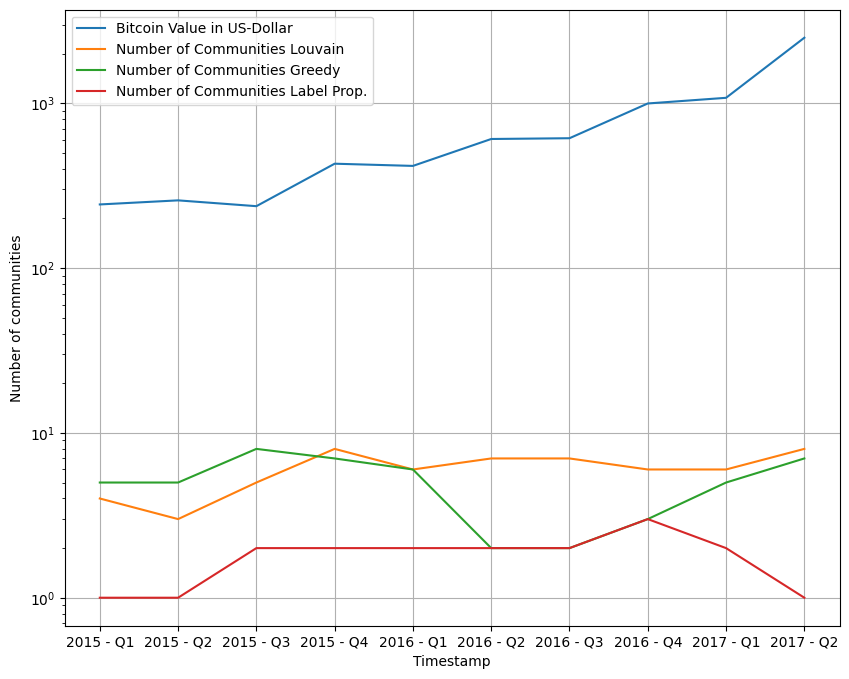

In [43]:
## Plot the number of nodes for quaters
louvain_communities = [4, 3, 5, 8, 6, 7, 7, 6, 6, 8]
greedy_communities  = [5, 5, 8, 7, 6, 2, 2, 3, 5, 7]
label_communities   = [1, 1, 2, 2, 2, 2, 2, 3, 2, 1]
bitcoin_values = [243.39, 257.66, 237.57, 430.05, 417.01, 607.37, 613.93, 997.69, 1079.75, 2499.98]
timestamp = ["2015 - Q1", "2015 - Q2", "2015 - Q3", "2015 - Q4", "2016 - Q1", "2016 - Q2", "2016 - Q3", "2016 - Q4", "2017 - Q1", "2017 - Q2"]
plt.figure(figsize=(10, 8))
plt.plot(timestamp, bitcoin_values, timestamp, louvain_communities, timestamp, greedy_communities, timestamp, label_communities)
plt.xlabel("Timestamp")
plt.ylabel("Number of communities")
plt.yscale('log')
plt.grid()
plt.legend(['Bitcoin Value in US-Dollar', 'Number of Communities Louvain', 'Number of Communities Greedy', 'Number of Communities Label Prop.'])
plt.show()

## Compute modularities for each date:

In [44]:
def partition_to_dict(partitions):
    ''' Convert a list of sets (communities) into a dictionary mapping each node to its community. '''
    partition_dict = {}
    for i, community in enumerate(partitions):
        for node in community:
            partition_dict[node] = i
    return partition_dict

def custom_draw_dynamic_new(G, n, algorithm):
    ''' Custom function that detects communities, calculates modularity, and returns modularity for a given algorithm. '''

    G = G.copy()  # Work on a copy of the graph to preserve the original graph

    # Remove nodes with degree less than n
    nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree < n]
    G.remove_nodes_from(nodes_to_remove)

    if G.number_of_nodes() == 0:
        return "Graph is empty after removing nodes with degree less than n."

    # Extract the largest component of the graph
    largest_cc = max(nx.connected_components(G), key=len)
    G_largest_cc = G.subgraph(largest_cc).copy()

    partition = None
    modularity = None

    if algorithm == 'louvain':
        partition = community_louvain.best_partition(G_largest_cc)
        modularity = community_louvain.modularity(partition, G_largest_cc)
    elif algorithm == 'greedy':
        communities = list(nx.community.greedy_modularity_communities(G_largest_cc))
        partition = partition_to_dict(communities)
        modularity = community_louvain.modularity(partition, G_largest_cc)
    elif algorithm == 'label':
        communities = list(nx.community.label_propagation_communities(G_largest_cc))
        partition = partition_to_dict(communities)
        modularity = community_louvain.modularity(partition, G_largest_cc)

    return modularity

{'louvain': 0.3106379722724265, 'greedy': -0.3296944605686886, 'label': 0.0}


In [47]:
# Execute for each date!

# Algorithms to be used
algorithms = ['louvain', 'greedy', 'label']

for i in range (10):
  modularities = {}
  for algorithm in algorithms:
    modularity = custom_draw_dynamic_new(graphs_list[i].to_undirected(), n=10, algorithm=algorithm)
    modularities[algorithm] = modularity
  print("Date: {}, Metrics: {}".format(all_dates[i].split('/')[-2], modularities))

Date: 2015-Q1, Metrics: {'louvain': 0.31118135117195467, 'greedy': -0.3296944605686886, 'label': 0.0}
Date: 2015-Q2, Metrics: {'louvain': 0.355596522189002, 'greedy': -0.25617954623247624, 'label': 0.0}
Date: 2015-Q3, Metrics: {'louvain': 0.35737171154969083, 'greedy': -0.08890080444559476, 'label': 0.00026971433341970526}
Date: 2015-Q4, Metrics: {'louvain': 0.48160387480507416, 'greedy': -0.10365023329904988, 'label': 0.01238471835407906}
Date: 2016-Q1, Metrics: {'louvain': 0.19725143335035863, 'greedy': 0.032622840261269014, 'label': 0.030598352321454678}
Date: 2016-Q2, Metrics: {'louvain': 0.42137460525223125, 'greedy': 0.11779808992217372, 'label': 0.1194141483058444}
Date: 2016-Q3, Metrics: {'louvain': 0.5428151582866169, 'greedy': 0.16039913606840822, 'label': 0.12908214057998224}
Date: 2016-Q4, Metrics: {'louvain': 0.4168351081873533, 'greedy': 0.037975227105895966, 'label': 0.035701422923016396}
Date: 2017-Q1, Metrics: {'louvain': 0.4590234950953168, 'greedy': -0.07316325883746

In [48]:
# End of notebook!